# NNDL - Extra - Q1

# Import Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

2024-06-30 08:41:53.700711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 08:41:53.700844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 08:41:53.879928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [2]:
# MNIST 
mnist = tf.keras.datasets.mnist
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Shape of Dataset

In [4]:
print("MNIST training data shape:", mnist_train_images.shape)
print("MNIST test data shape:", mnist_test_images.shape)
print("Fashion MNIST training data shape:", fashion_train_images.shape)
print("Fashion MNIST test data shape:", fashion_test_images.shape)

MNIST training data shape: (60000, 28, 28)
MNIST test data shape: (10000, 28, 28)
Fashion MNIST training data shape: (60000, 28, 28)
Fashion MNIST test data shape: (10000, 28, 28)


## Show Samples

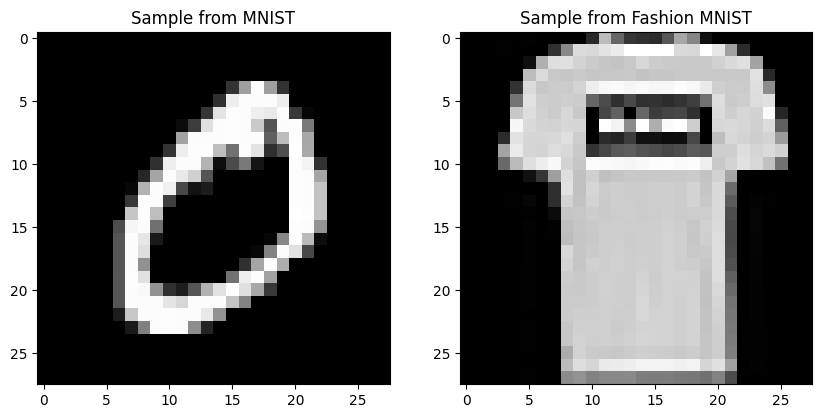

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mnist_train_images[1], cmap='gray')
plt.title('Sample from MNIST')

plt.subplot(1, 2, 2)
plt.imshow(fashion_train_images[1], cmap='gray')
plt.title('Sample from Fashion MNIST')

plt.show()

## Normalize the datasets

In [6]:
mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

## Split 25% of Train Data for validation

In [7]:
mnist_val_size = int(0.25 * mnist_train_images.shape[0])
fashion_val_size = int(0.25 * fashion_train_images.shape[0])

mnist_val_images = mnist_train_images[:mnist_val_size]
mnist_val_labels = mnist_train_labels[:mnist_val_size]
mnist_train_images = mnist_train_images[mnist_val_size:]
mnist_train_labels = mnist_train_labels[mnist_val_size:]

fashion_val_images = fashion_train_images[:fashion_val_size]
fashion_val_labels = fashion_train_labels[:fashion_val_size]
fashion_train_images = fashion_train_images[fashion_val_size:]
fashion_train_labels = fashion_train_labels[fashion_val_size:]


In [8]:
print("MNIST training set shape after split:", mnist_train_images.shape)
print("MNIST validation set shape:", mnist_val_images.shape)
print("Fashion MNIST training set shape after split:", fashion_train_images.shape)
print("Fashion MNIST validation set shape:", fashion_val_images.shape)

MNIST training set shape after split: (45000, 28, 28)
MNIST validation set shape: (15000, 28, 28)
Fashion MNIST training set shape after split: (45000, 28, 28)
Fashion MNIST validation set shape: (15000, 28, 28)


# Convolutional Autoencoder

In [9]:
def create_autoencoder():
    # Encoder
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  
    x = layers.MaxPooling2D((2, 2), padding='same')(x)                           
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)          
    x = layers.MaxPooling2D((2, 2), padding='same')(x)                          
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)         
    x = layers.Flatten()(x)                                                      
    latent = layers.Dense(6, activation='relu')(x)                               

    # Decoder
    x = layers.Dense(6272, activation='relu')(latent)
    x = layers.Reshape((7, 7, 128))(x)                                           
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)   
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)   
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)               

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, latent)
    autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    return autoencoder, encoder

## Check Model

In [10]:
autoencoder,encoder = create_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        37,638 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6272)           │        43,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,759 (1.02 MB)

 Trainable params: 266,759 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        37,638 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,310 (509.02 KB)

 Trainable params: 130,310 (509.02 KB)

 Non-trainable params: 0 (0.00 B)

# Train MNIST

In [13]:
mnist_autoencoder, mnist_encoder = create_autoencoder()

In [48]:
mnist_history = mnist_autoencoder.fit(
    mnist_train_images, mnist_train_images,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(mnist_val_images, mnist_val_images)
)

Epoch 1/10
  7/176 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2289 - mae: 0.4702

W0000 00:00:1719308304.836523     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719308304.839164     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1106 - mae: 0.2069

W0000 00:00:1719308308.850405     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719308309.843734     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1104 - mae: 0.2066 - val_loss: 0.0414 - val_mae: 0.0953
Epoch 2/10
  9/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0415 - mae: 0.0951

W0000 00:00:1719308310.751710     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0374 - mae: 0.0881 - val_loss: 0.0313 - val_mae: 0.0755
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0304 - mae: 0.0753 - val_loss: 0.0283 - val_mae: 0.0725
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0281 - mae: 0.0713 - val_loss: 0.0266 - val_mae: 0.0690
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0263 - mae: 0.0679 - val_loss: 0.0255 - val_mae: 0.0655
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0253 - mae: 0.0657 - val_loss: 0.0246 - val_mae: 0.0639
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0244 - mae: 0.0640 - val_loss: 0.0238 - val_mae: 0.0622
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0237 - mae: 0.0627 - val_loss: 0.0234 - val_mae: 0.0610
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0233 - mae: 0.0618 - val_loss: 0.0229 - val_mae: 0.0616
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - los

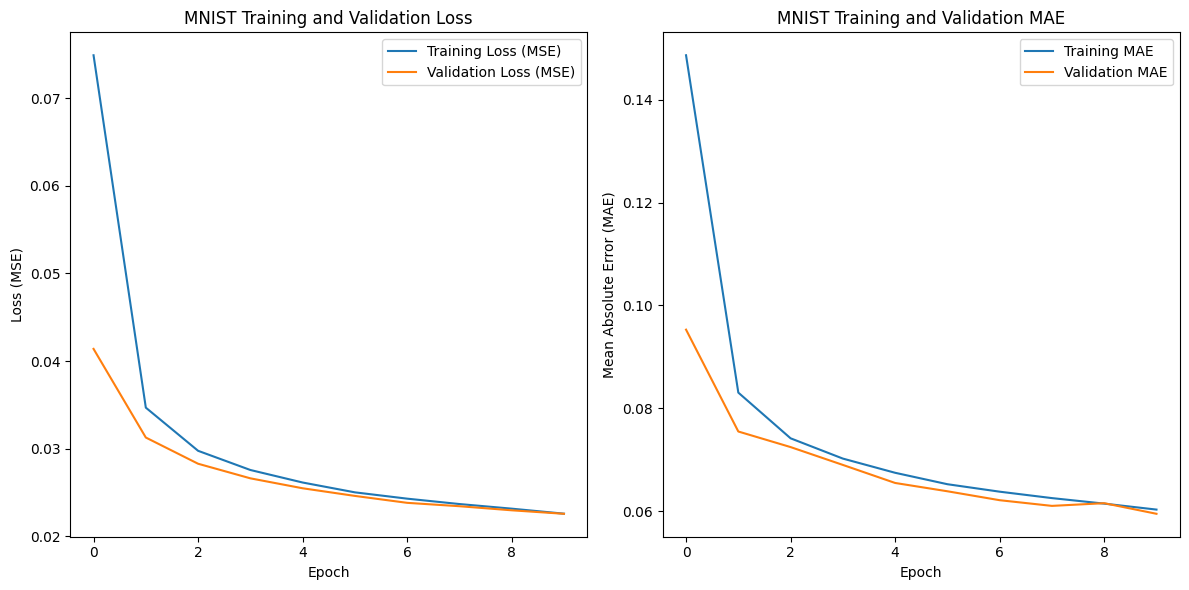

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mnist_history.history['loss'], label='Training Loss (MSE)')
plt.plot(mnist_history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('MNIST Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mnist_history.history['mae'], label='Training MAE')
plt.plot(mnist_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MNIST Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Train Fashion MNIST

In [14]:
fashion_autoencoder, fashion_encoder = create_autoencoder()

In [36]:
fashion_history = fashion_autoencoder.fit(
    fashion_train_images, fashion_train_images,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(fashion_val_images, fashion_val_images)
)

Epoch 1/10
  7/176 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1686 - mae: 0.3805

W0000 00:00:1719307756.160357     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719307756.162895     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0951 - mae: 0.2404

W0000 00:00:1719307760.216651     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719307761.224267     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0949 - mae: 0.2400 - val_loss: 0.0263 - val_mae: 0.0924
Epoch 2/10
  9/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0267 - mae: 0.0937

W0000 00:00:1719307762.129250     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0254 - mae: 0.0904 - val_loss: 0.0230 - val_mae: 0.0836
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0225 - mae: 0.0825 - val_loss: 0.0213 - val_mae: 0.0790
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0211 - mae: 0.0785 - val_loss: 0.0206 - val_mae: 0.0774
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0203 - mae: 0.0764 - val_loss: 0.0198 - val_mae: 0.0747
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0195 - mae: 0.0744 - val_loss: 0.0193 - val_mae: 0.0736
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0190 - mae: 0.0732 - val_loss: 0.0189 - val_mae: 0.0727
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0184 - mae: 0.0716 - val_loss: 0.0182 - val_mae: 0.0707
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0179 - mae: 0.0704 - val_loss: 0.0178 - val_mae: 0.0695
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - los

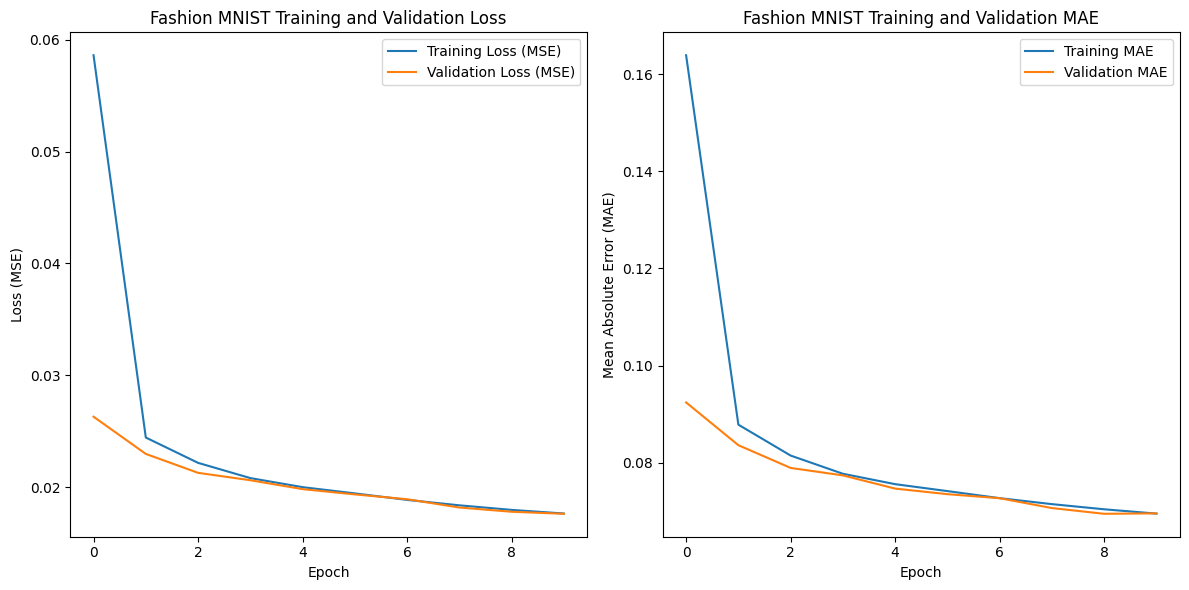

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fashion_history.history['loss'], label='Training Loss (MSE)')
plt.plot(fashion_history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Fashion MNIST Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fashion_history.history['mae'], label='Training MAE')
plt.plot(fashion_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Fashion MNIST Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Models

## MSE & MAE on Test data

In [50]:
mnist_test_mse, mnist_test_mae = mnist_autoencoder.evaluate(mnist_test_images, mnist_test_images, verbose=0)
fashion_test_mse, fashion_test_mae = fashion_autoencoder.evaluate(fashion_test_images, fashion_test_images, verbose=0)

print(f"MNIST Test MSE: {mnist_test_mse:.4f}, Test MAE: {mnist_test_mae:.4f}")
print(f"Fashion MNIST Test MSE: {fashion_test_mse:.4f}, Test MAE: {fashion_test_mae:.4f}")

MNIST Test MSE: 0.0225, Test MAE: 0.0595
Fashion MNIST Test MSE: 0.0177, Test MAE: 0.0701


## Display original and reconstructed images

In [39]:
def display_reconstructed_images(autoencoder, test_images, test_labels):
    num_classes = 10
    samples_per_class = 1
    
    fig, axes = plt.subplots(2, num_classes, figsize=(20, 4))    
    for i in range(num_classes):
        class_indices = np.where(test_labels == i)[0]
        sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        
        for j, sample_idx in enumerate(sample_indices):
            original_image = test_images[sample_idx]
            reconstructed_image = autoencoder.predict(original_image[np.newaxis, ...])[0]
            axes[0, i].imshow(original_image.squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if j == 0:
                axes[0, i].set_title(f'Class {i}')
            axes[1, i].imshow(reconstructed_image.squeeze(), cmap='gray')
            axes[1, i].axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


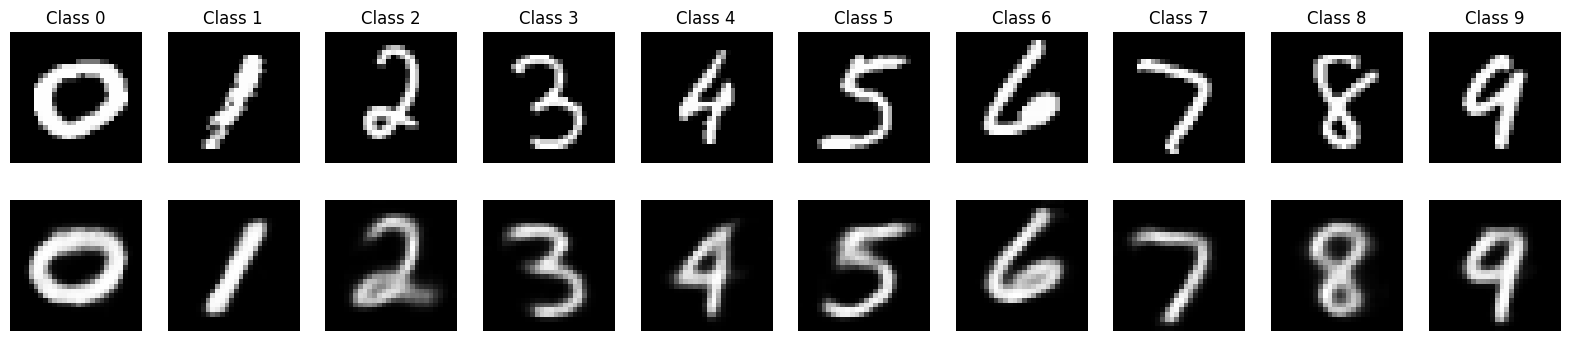

In [264]:
display_reconstructed_images(mnist_autoencoder, mnist_test_images, mnist_test_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


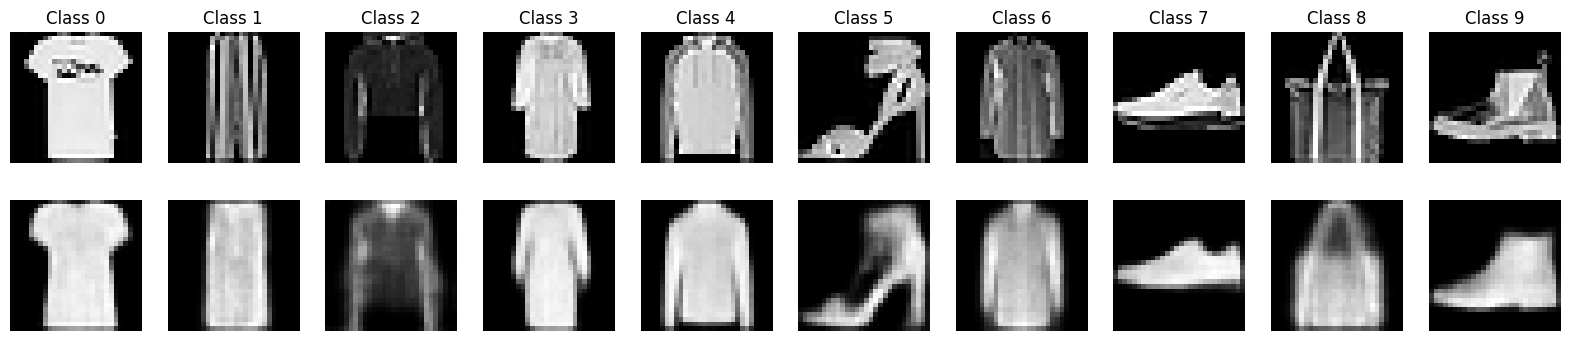

In [254]:
display_reconstructed_images(fashion_autoencoder, fashion_test_images, fashion_test_labels)

# Clustering

## MNIST

In [35]:
mnist_train_features = mnist_encoder.predict(mnist_train_images)
mnist_val_features = mnist_encoder.predict(mnist_val_images)
mnist_test_features = mnist_encoder.predict(mnist_test_images)
mnist_features = np.concatenate([mnist_train_features, mnist_val_features, mnist_test_features])

mnist_train_labels = np.array(mnist_train_labels)
mnist_val_labels = np.array(mnist_val_labels)
mnist_test_labels = np.array(mnist_test_labels)
mnist_labels = np.concatenate([mnist_train_labels, mnist_val_labels, mnist_test_labels])

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Fashion MNIST

In [36]:
fashion_train_features = fashion_encoder.predict(fashion_train_images)
fashion_val_features = fashion_encoder.predict(fashion_val_images)
fashion_test_features = fashion_encoder.predict(fashion_test_images)
fashion_features = np.concatenate([fashion_train_features, fashion_val_features, fashion_test_features])

fashion_train_labels = np.array(fashion_train_labels)
fashion_val_labels = np.array(fashion_val_labels)
fashion_test_labels = np.array(fashion_test_labels)
fashion_labels = np.concatenate([fashion_train_labels, fashion_val_labels, fashion_test_labels])

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## KMeans clustering - Silhouette Scores - MNIST

In [37]:
mnist_silhouette_scores = []
mnist_cluster_range = range(5, 16)

for n_clusters in mnist_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    mnist_cluster_labels = kmeans.fit_predict(mnist_features)
    silhouette_avg = silhouette_score(mnist_features, mnist_cluster_labels)
    mnist_silhouette_scores.append(silhouette_avg)
    print(f"MNIST: number of clusters = {n_clusters}, silhouette score = {silhouette_avg:.4f}")

MNIST: number of clusters = 5, silhouette score = 0.2131
MNIST: number of clusters = 6, silhouette score = 0.2236
MNIST: number of clusters = 7, silhouette score = 0.2175
MNIST: number of clusters = 8, silhouette score = 0.2269
MNIST: number of clusters = 9, silhouette score = 0.2278
MNIST: number of clusters = 10, silhouette score = 0.2263
MNIST: number of clusters = 11, silhouette score = 0.2232
MNIST: number of clusters = 12, silhouette score = 0.2135
MNIST: number of clusters = 13, silhouette score = 0.2041
MNIST: number of clusters = 14, silhouette score = 0.2067
MNIST: number of clusters = 15, silhouette score = 0.1999


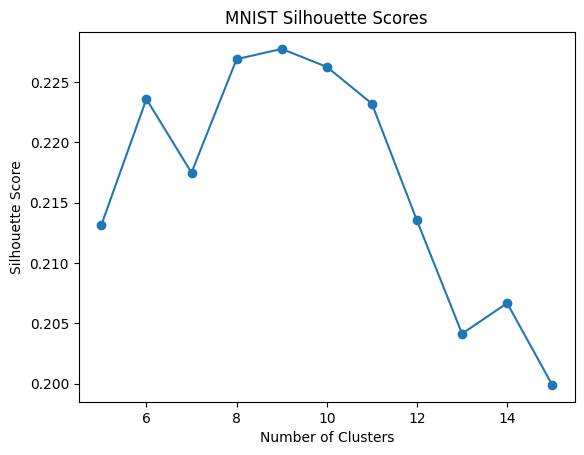

In [38]:
plt.plot(mnist_cluster_range, mnist_silhouette_scores, marker='o')
plt.title('MNIST Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## KMeans clustering - Silhouette Scores - Fashion MNIST

In [39]:
fashion_silhouette_scores = []
fashion_cluster_range = range(5, 16)

for n_clusters in fashion_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    fashion_cluster_labels = kmeans.fit_predict(fashion_features)
    silhouette_avg = silhouette_score(fashion_features, fashion_cluster_labels)
    fashion_silhouette_scores.append(silhouette_avg)
    print(f"Fashion MNIST: number of clusters = {n_clusters}, silhouette score = {silhouette_avg:.4f}")

Fashion MNIST: number of clusters = 5, silhouette score = 0.2985
Fashion MNIST: number of clusters = 6, silhouette score = 0.2898
Fashion MNIST: number of clusters = 7, silhouette score = 0.3021
Fashion MNIST: number of clusters = 8, silhouette score = 0.3014
Fashion MNIST: number of clusters = 9, silhouette score = 0.2877
Fashion MNIST: number of clusters = 10, silhouette score = 0.2670
Fashion MNIST: number of clusters = 11, silhouette score = 0.2761
Fashion MNIST: number of clusters = 12, silhouette score = 0.2801
Fashion MNIST: number of clusters = 13, silhouette score = 0.2818
Fashion MNIST: number of clusters = 14, silhouette score = 0.2750
Fashion MNIST: number of clusters = 15, silhouette score = 0.2717


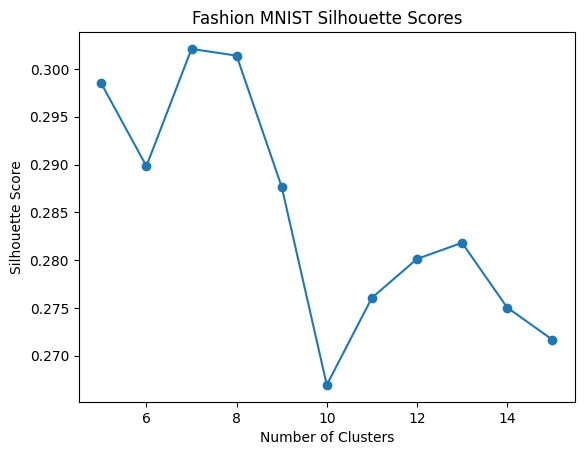

In [40]:
plt.plot(fashion_cluster_range, fashion_silhouette_scores, marker='o')
plt.title('Fashion MNIST Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [42]:
optimal_clusters_mnist = 9
optimal_clusters_fashion = 7

## KMeans on MNIST

In [43]:
kmeans_mnist = KMeans(n_clusters=optimal_clusters_mnist, random_state=42, n_init=10)
mnist_cluster_labels = kmeans_mnist.fit_predict(mnist_features)
mnist_cluster_label_distribution = np.zeros((optimal_clusters_mnist, 10))

for i in range(optimal_clusters_mnist):
    cluster_indices = np.where(mnist_cluster_labels == i)
    labels_in_cluster = mnist_labels[cluster_indices]
    label_counts = np.bincount(labels_in_cluster, minlength=10)
    mnist_cluster_label_distribution[i, :] = label_counts

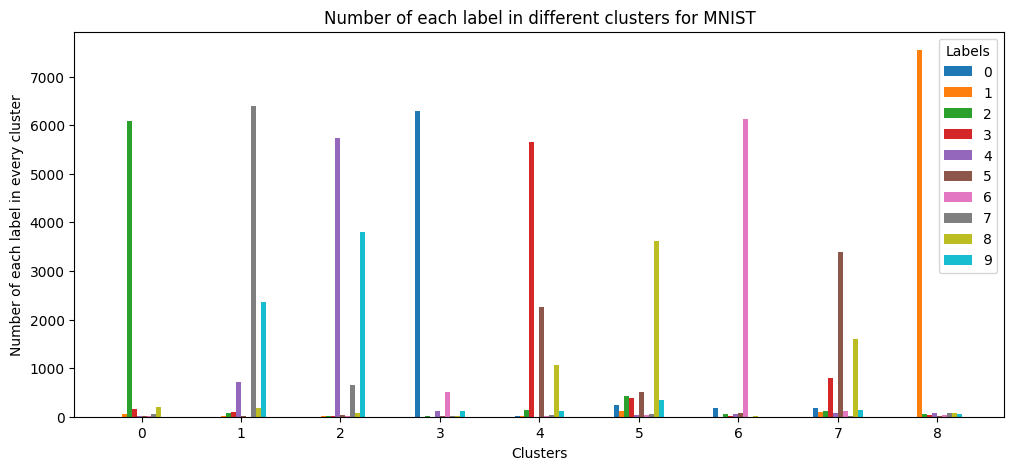

In [64]:
ind = np.arange(optimal_clusters_mnist)
width = 0.05  

fig, ax = plt.subplots(figsize=(12, 5))

for label in range(10):
    ax.bar(ind + label * width, mnist_cluster_label_distribution[:, label], width, label=str(label))

ax.set_xticks(ind + width * 4.5)
ax.set_xticklabels(ind)
ax.set_title('Number of each label in different clusters for MNIST')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of each label in every cluster')
ax.legend(title="Labels", loc='upper right')
plt.show()

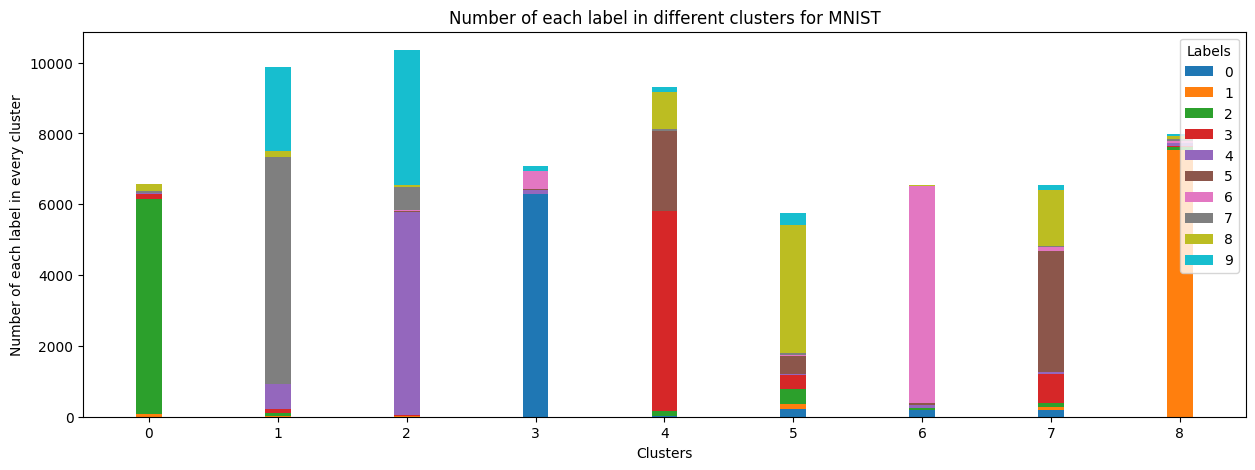

In [88]:
ind = np.arange(optimal_clusters_mnist)
width = 0.2
fig, ax = plt.subplots(figsize=(15, 5))
bottom = np.zeros(optimal_clusters_mnist)

for label in range(10):
    ax.bar(ind, mnist_cluster_label_distribution[:, label], width, bottom=bottom, label=str(label))
    bottom += mnist_cluster_label_distribution[:, label]
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_title('Number of each label in different clusters for MNIST')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of each label in every cluster')
ax.legend(title="Labels", loc='upper right')
plt.show()

## KMeans on Fashion MNIST

In [89]:
kmeans_fashion = KMeans(n_clusters=optimal_clusters_fashion, random_state=42, n_init=10)
fashion_cluster_labels = kmeans_fashion.fit_predict(fashion_features)

fashion_cluster_label_distribution = np.zeros((optimal_clusters_fashion, 10))

for i in range(optimal_clusters_fashion):
    cluster_indices = np.where(fashion_cluster_labels == i)
    labels_in_cluster = fashion_labels[cluster_indices]
    label_counts = np.bincount(labels_in_cluster, minlength=10)
    fashion_cluster_label_distribution[i, :] = label_counts

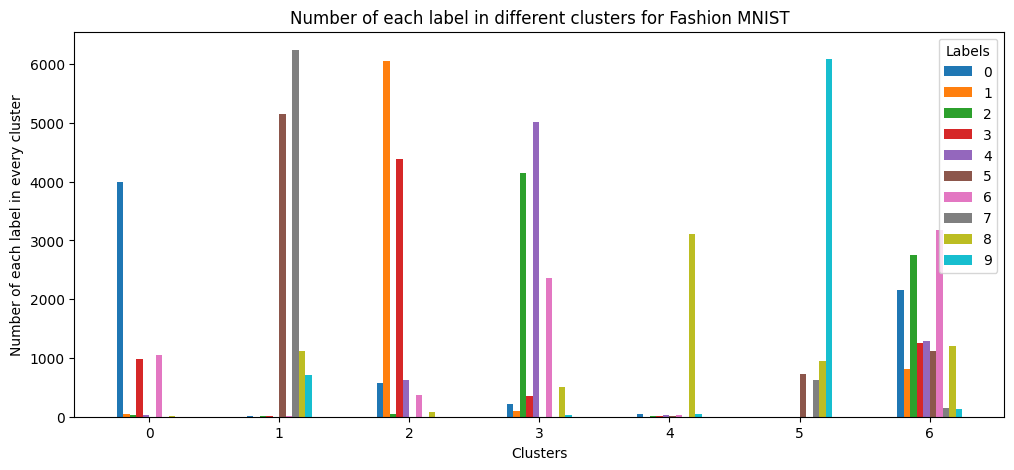

In [90]:
ind = np.arange(optimal_clusters_fashion)
width = 0.05  

fig, ax = plt.subplots(figsize=(12, 5))

for label in range(10):
    ax.bar(ind + label * width, fashion_cluster_label_distribution[:, label], width, label=str(label))

ax.set_xticks(ind + width * 4.5)
ax.set_xticklabels(ind)
ax.set_title('Number of each label in different clusters for Fashion MNIST')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of each label in every cluster')
ax.legend(title="Labels", loc='upper right')
plt.show()

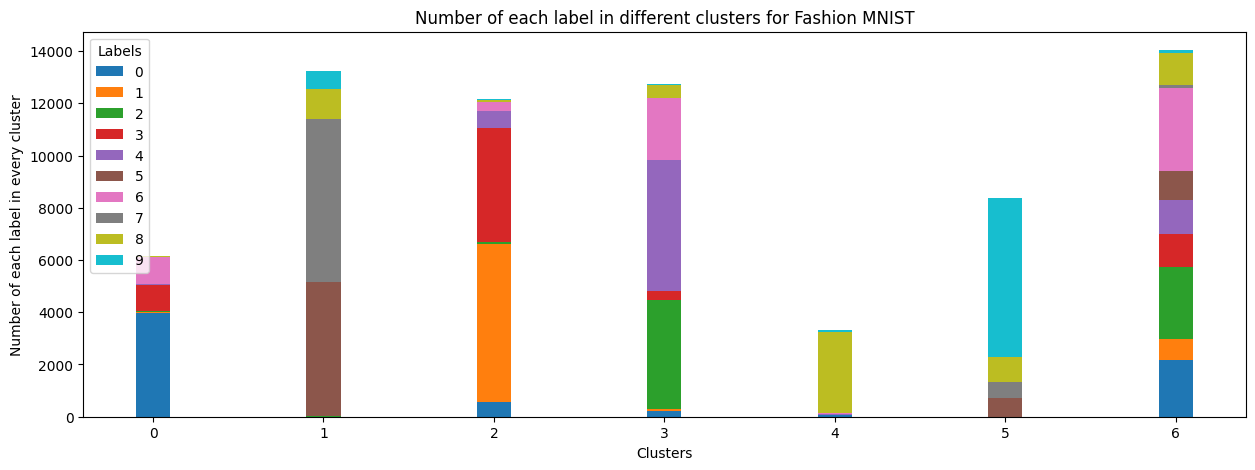

In [91]:
ind = np.arange(optimal_clusters_fashion)

width = 0.2
fig, ax = plt.subplots(figsize=(15, 5))
bottom = np.zeros(optimal_clusters_fashion)

for label in range(10):
    ax.bar(ind, fashion_cluster_label_distribution[:, label], width, bottom=bottom, label=str(label))
    bottom += fashion_cluster_label_distribution[:, label]

ax.set_title('Number of each label in different clusters for Fashion MNIST')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of each label in every cluster')
ax.set_xticks(ind)  
ax.legend(title="Labels")
plt.show()